<a href="https://colab.research.google.com/github/candrea/AnalisisPZI/blob/main/PruebaTecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from google.colab import drive
#drive.mount('/content/drive')
#engine = create_engine('sqlite:////content/drive/MyDrive/Colab Notebooks/newspaper.db')
engine = create_engine('sqlite:///:memory:')

Session = sessionmaker(bind=engine)

Base = declarative_base()

In [4]:
from sqlalchemy import Column, String, Integer
#import Base
class Article(Base):
    __tablename__ = 'PIB'

    DIVIPOLA = Column(Integer, primary_key=True)
    DEPARTAMENTO = Column(String)
    _2020 = Column(Integer)
   

    def __init__(self,
                 DIVIPOLA,
                 DEPARTAMENTO,
                 _2020):
        self.id = DIVIPOLA
        self.DIVIPOLA= DIVIPOLA
        self.DEPARTAMENTO = DEPARTAMENTO
        self._2020= _2020

class Institucion(Base):
    __tablename__ = 'Instituciones'
    codigo_institucion = Column(Integer, primary_key=True)
    divipola= Column(String)
    departamento = Column(Integer)
    certificado_calidad = Column(String)
    anno_corte = Column(Integer)
   

    def __init__(self,
                 codigo_institucion,
                 cod_dpto,
                 departamento,
                 certificado_calidad,
                 año_corte):
        self.id = codigo_institucion
        self.divipola= cod_dpto
        self.departamento = departamento
        self.certificado_calidad = certificado_calidad
        self.anno_corte= año_corte
       


In [5]:
import argparse
import logging
logging.basicConfig(level=logging.INFO)
import pandas as pd
import requests
import io
parser = argparse.ArgumentParser()
logger = logging.getLogger(__name__)
Base.metadata.create_all(engine)


session = Session()

url ="https://raw.githubusercontent.com/candrea/AnalisisPZI/main/PIB_DEPARTAMENTOS.csv" #"https://github.com/candrea/AnalisisPZI/blob/main/PIB_departamento.csv"
url2 = "https://raw.githubusercontent.com/candrea/AnalisisPZI/main/INSTITUCIONES_TRABAJO.csv"
#s = requests.get(url).content
#c = pd.read_csv(s)
s = requests.get(url, verify=False).content
s2 = requests.get(url2, verify=False).content
#articles = pd.read_csv(io.StringIO(s.decode('utf-8')))
articles = pd.read_csv(url, sep = ';', on_bad_lines='skip')
instituciones = pd.read_csv(url2, sep = ';', on_bad_lines='skip')
#articles
#articles = pd.read_csv(s)
for index, row in articles.iterrows():
  
  logger.info('Loading DIVIPOLA {} into DB'.format(row['DIVIPOLA']))
  article = Article(row['DIVIPOLA'],
                    row['DEPARTAMENTO'],
                    row['_2020'])

  
  session.add(article)
for index, row in instituciones.iterrows():
  
  #logger.info('Loading institucion {} into DB'.format(row['codigo_institucion']))
  institucion = Institucion(row['codigo_institucion'],
                            row['cod_dpto'],
                            row['departamento'],
                            row['certificado_calidad'],
                            row['año_corte'])

  session.add(institucion)


session.commit()

session.close()




/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:__main__:Loading DIVIPOLA 91 into DB
INFO:__main__:Loading DIVIPOLA 5 into DB
INFO:__main__:Loading DIVIPOLA 81 into DB
INFO:__main__:Loading DIVIPOLA 8 into DB
INFO:__main__:Loading DIVIPOLA 11 into DB
INFO:__main__:Loading DIVIPOLA 13 into DB
INFO:__main__:Loading DIVIPOLA 15 into DB
INFO:__main__:Loading DIVIPOLA 17 into DB
INFO:__main__:Loading DIVIPOLA 18 into DB
INFO:__main__:Loading DIVIPOLA 85 into D

In [30]:
from sqlalchemy.sql import text
conn = engine.connect()
conn
session = Session()
s = text(
"SELECT divipola, departamento, SUM(CASE WHEN certificado_calidad='SI' THEN 1 ELSE 0 END)  as certificadas,"
"SUM(CASE WHEN certificado_calidad='NO' THEN 1 ELSE 0 END)   AS no_certificadas,"
"COUNT(1) as total "
"FROM instituciones  GROUP BY 1")
t = text(
"SELECT DIVIPOLA, DEPARTAMENTO, SUM(_2020) AS PIB FROM PIB GROUP BY 1,2"
)
t1= text (
"with min as (select divipola,departamento, round(avg(_2020),2) as min_PIB from PIB  group by 1,2 order by 3 limit 3), "
" max as (select divipola,departamento, round(avg(_2020),2) as max_PIB from PIB   group by 1,2 order by 3 DESC limit 3),"
" avg as (select  round(avg(_2020),2) as avg_PIB from PIB)"
" select divipola,departamento, min_PIB as PIB from min union all"
" select divipola,departamento, max_PIB from max"
" UNION ALL select '' AS divipola, 'Media' AS departamento, avg_PIB from avg"
    
)
tt= text (
"select p.divipola,p.departamento,SUM(CASE WHEN certificado_calidad='SI' THEN 1 ELSE 0 END)  as certificadas,"
"SUM(CASE WHEN certificado_calidad='NO' THEN 1 ELSE 0 END)   AS no_certificadas,"
"COUNT(distinct codigo_institucion) as total, round(avg(_2020),2) as PIB "
"from PIB p left join instituciones i on p.divipola=i.divipola group by 1,2"
    
)
conn.execute(t1).fetchall()

[(97, 'Vaupés', 287.0),
 (94, 'Guainía', 366.0),
 (99, 'Vichada', 676.0),
 (11, 'Bogotá D.C.', 260207.0),
 (5, 'Antioquia', 148387.0),
 (76, 'Valle del Cauca', 99700.0),
 ('', 'Media', 30264.21)]

In [31]:
df_instituciones = pd.read_sql(s,conn)
df_PIB = pd.read_sql(t,conn)
df_data = pd.read_sql(tt,conn)
median_value = np.percentile(df_data.PIB, 50) 
print(median_value)
df_resumen_data = pd.read_sql(t1,conn)
A = {'divipola':'','departamento':'Mediana','PIB':median_value}
df_resumen_data=df_resumen_data.append(A,ignore_index=True)
df_resumen_data


15740.0


,divipola,departamento,PIB
0,97,Vaupés,287.00
1,94,Guainía,366.00
2,99,Vichada,676.00
3,11,Bogotá D.C.,260207.00
4,5,Antioquia,148387.00
5,76,Valle del Cauca,99700.00
6,,Media,30264.21
7,,Mediana,15740.00


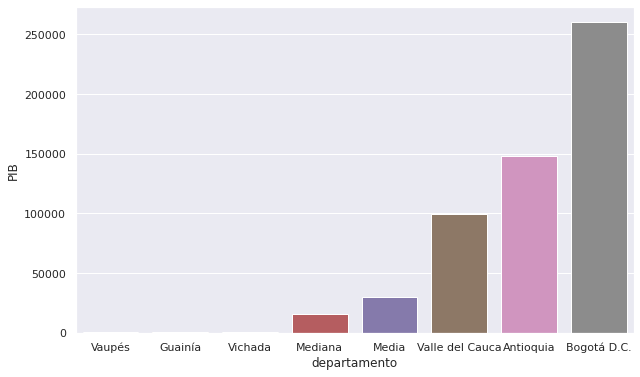

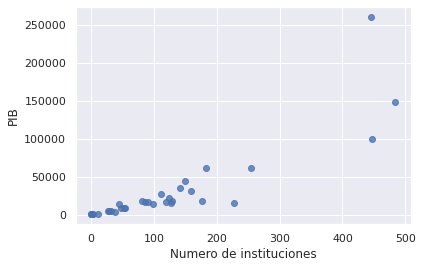

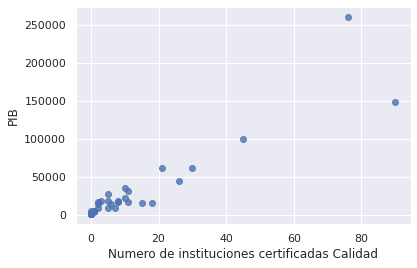

In [33]:
#Graphic analysis
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(rc = {'figure.figsize':(10,6)})
sns.barplot(x='departamento', 
            y="PIB", data=df_resumen_data,  
            order=df_resumen_data.sort_values('PIB').departamento)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=df_data.total, y=df_data.PIB, alpha= 0.8)
ax.set_xlabel('Numero de instituciones')
ax.set_ylabel('PIB');
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=df_data.certificadas, y=df_data.PIB, alpha= 0.8)
ax.set_xlabel('Numero de instituciones certificadas Calidad')
ax.set_ylabel('PIB');

In [40]:
import statsmodels.api as sm
!pip install pingouin


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 183 kB 5.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 41.2 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=34ae0480b08f79e13544ca46deb5f0f59b0a2edd28377d207f24d2eae9edf787
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=9ff1ba0323ca71be601892236271c5827d1cb1abe768f38e6202f5e067890552
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsm

Variable Instituciones: ShapiroResult(statistic=0.7957093715667725, pvalue=2.676149051694665e-05)
Variable PIB: ShapiroResult(statistic=0.5647419691085815, pvalue=9.946437451446855e-09)
Variable Instituciones: Estadítico = 17.749481462175076, p-value = 0.0001398778898815727
Variable PIB: Estadítico = 47.98754054309738, p-value = 3.798726015288439e-11


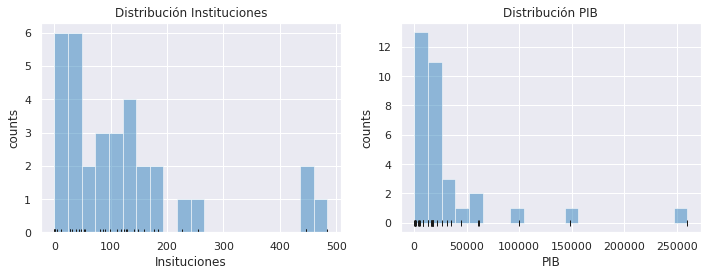

In [9]:
# Gráfico distribución variables
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pingouin as pg
from scipy import stats
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=df_data.total, bins=20, color="#3182bd", alpha=0.5)
axs[0].plot(df_data.total, np.full_like(df_data.total, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución Instituciones')
axs[0].set_xlabel('Insituciones')
axs[0].set_ylabel('counts')

axs[1].hist(x=df_data.PIB, bins=20, color="#3182bd", alpha=0.5)
axs[1].plot(df_data.PIB, np.full_like(df_data.PIB, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución PIB')
axs[1].set_xlabel('PIB')
axs[1].set_ylabel('counts')
plt.tight_layout();


shapiro_test = stats.shapiro(df_data.total)
print(f"Variable Instituciones: {shapiro_test}")
shapiro_test = stats.shapiro(df_data.PIB)
print(f"Variable PIB: {shapiro_test}")# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(df_data.total)
print(f"Variable Instituciones: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(df_data.PIB)
print(f"Variable PIB: Estadítico = {k2}, p-value = {p_value}")

In [12]:
# Cálculo de correlación, significancia e intervalos con pingouin
# ==============================================================================

display(pg.corr(df_data['total'], df_data['PIB'], method='skipped'))
display(pg.corr(df_data['total'], df_data['PIB'], method='shepherd'))
display(pg.corr(df_data['total'], df_data['PIB'], method='kendall'))
display(pg.corr(df_data['total'], df_data['PIB'], method='spearman'))

/usr/local/lib/python3.7/dist-packages/pingouin/correlation.py:128: UserWarning: The skipped correlation relies on the Minimum Covariance Determinant algorithm, which gives slightly different results in Python (scikit-learn) than in the original Matlab library (LIBRA). As such, the skipped correlation may be different from the Matlab robust correlation toolbox (see issue 164 on Pingouin's GitHub). Make sure to double check your results or use another robust correlation method.
  "The skipped correlation relies on the Minimum Covariance Determinant "


,n,outliers,r,CI95%,p-val,power
skipped,33,5,0.900082,"[0.79, 0.95]",7.109347e-11,1.0


,n,outliers,r,CI95%,p-val,power
shepherd,33,4,0.949495,"[0.89, 0.98]",4.093444e-15,1.0


,n,r,CI95%,p-val,power
kendall,33,0.79317,"[0.62, 0.89]",9.281099e-11,0.999971


,n,r,CI95%,p-val,power
spearman,33,0.932977,"[0.87, 0.97]",2.654317e-15,1.0
